In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport

## modelado
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from pandas.plotting import scatter_matrix
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

/opt/anaconda3/envs/Mineria/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define a function to check for special characters
def has_special_characters(record):
    # Regular expression to match special characters
    return bool(re.search(r'[^a-zA-Z0-9\s]', record))


In [3]:
def check_possible_dummyable_variables(data, max_unique_values=10):
    """
    Check for possible dummyable variables in the DataFrame and return a DataFrame
    with column names, their number of unique values and ammount of NaN.

    Parameters:
    - data: pd.DataFrame
        The DataFrame to check.
    - max_unique_values: int
        The maximum number of unique values for a variable to be considered dummyable.

    Returns:
    - dummyable_vars_df: pd.DataFrame
        A DataFrame with two columns: 'Column' (column names), 'UniqueValues' (number of unique values) and 'TotalNan' (number of Nan).
    """
    dummyable_vars = []

    for col in data.columns:
        if ((data[col].dtype == 'object') | (data[col].dtype == 'category')) and len(data[col].unique()) < max_unique_values:
            nanValues = data[col].isna().sum()
            dummyable_vars.append({'Column': col, 'UniqueValues': len(data[col].unique()), 'TotalNan':  str(nanValues)})

    # Convert the list of dictionaries to a DataFrame
    dummyable_vars_df = pd.DataFrame(dummyable_vars)

    return dummyable_vars_df


In [4]:
def check_high_frequency_categories(data, min_unique_values=10):
    """
    Check for variables that have more than min_unique_values categories in the DataFrame and return a DataFrame
    with column names and their number of unique values.

    Parameters:
    - data: pd.DataFrame
        The DataFrame to check.
    - max_unique_values: int
        The maximum number of unique values for a variable to be considered dummyable.

    Returns:
    - dummyable_vars_df: pd.DataFrame
        A DataFrame with two columns: 'Column' (column names), 'UniqueValues' (number of unique values) and 'TotalNan' (number of Nan).
    """
    dummyable_vars = []

    for col in data.columns:
        if ((data[col].dtype == 'object') | (data[col].dtype == 'category')) and len(data[col].unique()) >= min_unique_values:
            nanValues = data[col].isna().sum()
            dummyable_vars.append({'Column': col, 'UniqueValues': len(data[col].unique()), 'TotalNan':  str(nanValues)})

    # Convert the list of dictionaries to a DataFrame
    dummyable_vars_df = pd.DataFrame(dummyable_vars)

    return dummyable_vars_df


In [5]:
def saca_metricas(y1, y2):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_auc_score, roc_curve
    import plotly.graph_objects as go
    import numpy as np

    print('Matriz de Confusión')
    print(confusion_matrix(y1, y2))
    print('Accuracy:', accuracy_score(y1, y2))
    print('Precision:', precision_score(y1, y2, average='weighted'))
    print('Recall:', recall_score(y1, y2, average='weighted'))
    print('F1 Score:', f1_score(y1, y2, average='weighted'))

    # ROC and AUC for multiclass
    try:
        classes = np.unique(y1)
        y1_bin = label_binarize(y1, classes=classes)
        y2_bin = label_binarize(y2, classes=classes)

        # Calculate ROC curve and AUC for each class
        fig = go.Figure()
        for i, class_label in enumerate(classes):
            fpr, tpr, _ = roc_curve(y1_bin[:, i], y2_bin[:, i])
            auc_score = roc_auc_score(y1_bin[:, i], y2_bin[:, i])
            fig.add_trace(go.Scatter(
                x=fpr, y=tpr, mode='lines',
                name=f'Class {class_label} (AUC = {auc_score:.2f})'
            ))

        # Add diagonal line
        fig.add_trace(go.Scatter(
            x=[0, 1], y=[0, 1], mode='lines',
            name='Random Guess', line=dict(dash='dash', color='red')
        ))

        # Update layout
        fig.update_layout(
            title='ROC Curve (Multiclass)',
            xaxis_title='False Positive Rate',
            yaxis_title='True Positive Rate',
            template='plotly_white'
        )
        fig.show()
    except ValueError as e:
        print("ROC and AUC calculation failed:", e)

In [6]:
def plot_feature_importance(model, X_train):
    feat_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
    
    fig = px.bar(feat_importances, x=feat_importances.index, y='Importance', title='Feature Importances', labels={'x': 'Features', 'Importance': 'Importance'}, template='plotly_white')
    fig.show()

    return feat_importances

In [7]:
def plot_target_vs_features(var, target, df):
    proporcion = pd.DataFrame()
    proporcion['%'] = df[target].groupby(df[var]).mean() * 100
    proporcion['Conteo'] = df[target].groupby(df[var]).count()
    proporcion = proporcion.round(3)
    proporcion_filtered = proporcion[(proporcion['%'] > 0) & (proporcion['Conteo'] > 10)]
    
    if len(proporcion_filtered) < 100 and len(proporcion_filtered) > 1:
        fig = px.bar(proporcion_filtered, x=proporcion_filtered.index, y='Conteo', title=f'Distribución de {var}', labels={'x': var, 'Conteo': 'Cantidad'}, template='plotly_white')
        fig.add_trace(go.Scatter(x=proporcion_filtered.index, y=proporcion_filtered['%'], mode='lines+markers', name='%', yaxis='y2', line=dict(color='green')))
        
        fig.update_layout(
            yaxis2=dict(title='%', overlaying='y', side='right')
        )
    elif len(proporcion_filtered) >= 100:
        df_filtered = df[[var, target]].dropna()
        df_filtered['bin'] = pd.qcut(df_filtered[var], q=20, duplicates='drop')
        bin_means = df_filtered.groupby('bin')[target].mean() * 100
        bin_counts = df_filtered.groupby('bin')[target].count()
        
        fig = go.Figure()
        fig.add_trace(go.Bar(x=bin_means.index.astype(str), y=bin_counts, name='Conteo', yaxis='y', marker_color='blue'))
        fig.add_trace(go.Scatter(x=bin_means.index.astype(str), y=bin_means, mode='lines+markers', name='%', yaxis='y2', line=dict(color='green')))
        
        fig.update_layout(
            title=f'Relación entre {var} y {target}',
            xaxis_title=f'Binned {var}',
            yaxis=dict(title='Conteo'),
            yaxis2=dict(title='%', overlaying='y', side='right'),
            template='plotly_white'
        )
    else:
        proporcion_filtered.reset_index(inplace=True)
        fig = px.scatter(proporcion_filtered, x=var, y='%', trendline='ols', title=f'Relación entre {var} y % Depósitos', template='plotly_white')
    
    fig.show()

# Inspección de variables
Cargar los documentos y revisar variables categóricas y numericas

In [8]:
df_train = pd.read_csv('training_values.csv', delimiter=',')
df_label = pd.read_csv('training_labels.csv', delimiter=',')
df_test = pd.read_csv('Test.csv', delimiter=',')

print(df_train.shape)
print(df_label.shape)
print('------')
print(df_test.shape)

(59400, 40)
(59400, 2)
------
(14850, 40)


In [9]:
# Todo:
# Combinar df_pump y df_test para aplicar las transformaciones en ambos dataframes - crear una columna para identificar los dataframes de origen
# Validar Id's
# Verificar tipologia de variables
# Valores fuera de rango
# Eliminar las variables que no aportan información
# Verificar si hay valores nulos

In [10]:
df_train['original_file'] = 'train'
df_test['original_file'] = 'test'

# Concatenate the train and test DataFrames
# to apply transformations on both dataframes
# and create a column to identify the source DataFrame

df_pump = pd.concat([df_train, df_test], axis=0)
df_pump.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74250 entries, 0 to 14849
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74250 non-null  int64  
 1   amount_tsh             74250 non-null  float64
 2   date_recorded          74250 non-null  object 
 3   funder                 69743 non-null  object 
 4   gps_height             74250 non-null  int64  
 5   installer              69718 non-null  object 
 6   longitude              74250 non-null  float64
 7   latitude               74250 non-null  float64
 8   wpt_name               74248 non-null  object 
 9   num_private            74250 non-null  int64  
 10  basin                  74250 non-null  object 
 11  subvillage             73780 non-null  object 
 12  region                 74250 non-null  object 
 13  region_code            74250 non-null  int64  
 14  district_code          74250 non-null  int64  
 15  lga    

In [11]:
print(df_pump['id'].duplicated().value_counts())
print(df_label['id'].duplicated().value_counts())

id
False    74250
Name: count, dtype: int64
id
False    59400
Name: count, dtype: int64


In [12]:
print(df_label['id'].isin(df_pump['id']).value_counts())

id
True    59400
Name: count, dtype: int64


In [13]:
var_categoricas = df_pump.select_dtypes(include=['object','category']).columns
var_num = df_pump.select_dtypes(exclude=['object','category']).columns

In [14]:
df_pump.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... water_quality  \
0  34.938093  -9.856322                  none            0  ...          soft   
1  34.698766  -2.147466              Zahanati            0  ...          soft   
2  37.460664  -3.821329           Kwa Mahundi            0  ...          soft   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...          soft   
4  31.130847  -1.825359               Shuleni            0  ...          soft   

  quality_group      quantity  quantity_group                source  \
0          good        enough          enough                spring   
1          good  insufficient    insufficient  rainwater harvesting   
2          good        enough          enough                   dam   
3          good           dry             dry           machine dbh   
4          good      seasonal        seasonal  rainwater harvesting   

            source_type source_class              waterpoint_type  \
0                spring  groundwater           communal standpipe   
1  rainwater harvesting      surface           communal standpipe   
2                   dam      surface  communal standpipe multiple   
3              borehole  groundwater  communal standpipe multiple   
4  rainwater harvesting      surface           communal standpipe   

  waterpoint_type_group original_file  
0    communal standpipe         train  
1    communal standpipe         train  
2    communal standpipe         train  
3    communal standpipe         train  
4    communal standpipe         train  

[5 rows x 41 columns]

In [15]:
# Analizar las variables de forma individual desde el reporte
pr = ProfileReport(df=df_pump)
pr.to_file('.reports/reporte.html')

Summarize dataset:  90%|████████▉ | 43/48 [00:01<00:00, 16.07it/s, Calculate auto correlation]      /opt/anaconda3/envs/Mineria/lib/python3.11/site-packages/ydata_profiling/model/correlations.py:87: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'cannot reindex on an axis with duplicate labels')
  warnings.warn(
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 220.51it/s]


# Tipología de variables

In [16]:
# Clasifico las variables por conceptos: tipo date, personas, zona, pozo y costos - de acuerdo a alguna caracteristicas común
# Para analizar en caso de que se necesite hacer inferencia
tipo_date = ['date_recorded']
tipo_zona = ["wpt_name", "basin", "subvillage", "region", "lga", "ward", "gps_height", "longitude", "latitude", "region_code", "district_code"]
tipo_costos = ['payment','payment_type']
tipo_personas = ["funder", "installer", "public_meeting", "recorded_by", "scheme_management", "scheme_name", "management", "management_group"]
tipo_pozo = ["permit", "extraction_type", "extraction_type_group", "extraction_type_class", "water_quality", "quality_group", "quantity", "quantity_group", "source", "source_type", "source_class", "waterpoint_type", "waterpoint_type_group", "amount_tsh", "population", "construction_year"]



In [17]:
# En latitude, los valores muy pequeños, los transformo a cero
# Correcciones para trabajar con latitud/lomguitud antes de reemplazar con las columnas dummies y reemplazo con frecuencia
threshold = 1e-6
df_pump['latitude'] = df_pump['latitude'].apply(lambda x: 0 if abs(x) < threshold else x)

In [18]:
df_subvillage_nonzero = df_pump[((df_pump['longitude'] != 0) & (df_pump['latitude'] != 0))][tipo_zona]

subvillaje_med_location = df_subvillage_nonzero.groupby(['subvillage']).agg(
    {
        'longitude': 'median',
        'latitude': 'median'
    }
)

df_subvillage_error = df_pump[((df_pump['longitude'] == 0) | (df_pump['latitude'] == 0))][tipo_zona]


In [19]:
subvillaje_med_location.reset_index(inplace=True)
subvillaje_med_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20617 entries, 0 to 20616
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   subvillage  20617 non-null  object 
 1   longitude   20617 non-null  float64
 2   latitude    20617 non-null  float64
dtypes: float64(2), object(1)
memory usage: 483.3+ KB


In [20]:
df_pump = df_pump.merge(subvillaje_med_location, on='subvillage', how='left', suffixes=('','_median'))


In [21]:
df_pump['latitude'] = df_pump.apply(lambda x: x['latitude_median'] if x['latitude'] == 0 else  x['latitude'] , axis=1)
df_pump['longitude'] = df_pump.apply(lambda x: x['longitude_median'] if x['longitude'] == 0 else  x['longitude'] , axis=1)

In [22]:
df_pump.drop(columns=['latitude_median', 'longitude_median'], inplace=True)

In [23]:
dummyable_cat = check_possible_dummyable_variables(df_pump, 15)
dummyable_cat.sort_values(by='UniqueValues', ascending=False)

Column  UniqueValues TotalNan
5   extraction_type_group            13        0
3       scheme_management            12     4847
7              management            12        0
15                 source            10        0
0                   basin             9        0
11          water_quality             8        0
9                 payment             7        0
18        waterpoint_type             7        0
16            source_type             7        0
10           payment_type             7        0
6   extraction_type_class             7        0
12          quality_group             6        0
19  waterpoint_type_group             6        0
8        management_group             5        0
13               quantity             5        0
14         quantity_group             5        0
1          public_meeting             3     4155
4                  permit             3     3793
17           source_class             3        0
20          original_file             2        0
2             recorded_by             1        0

In [24]:
#Analizar permit, public_meeting, scheme_management
# df_pump.recorded_by.value_counts(dropna=False)
#Eliminar recorded_by

#df_pump.permit.value_counts(dropna=False)
# reemplazar nan for unkown

# df_pump.public_meeting.value_counts(dropna=False, normalize=True)
# reemplazar nan for unkown

#df_pump.scheme_management.value_counts(dropna=False, normalize=True)
# reemplazar nan for unkown


In [25]:
# Gestionando los NaN
df_pump['permit'] = df_pump['permit'].apply(lambda x: 'Unknown' if pd.isna(x) else x)
df_pump['public_meeting'] = df_pump['public_meeting'].apply(lambda x: 'Unknown' if pd.isna(x) else x)
df_pump['scheme_management'] = df_pump['scheme_management'].apply(lambda x: 'Unknown' if pd.isna(x) else x)

In [26]:

# df_pump.extraction_type_group.value_counts(dropna=False, normalize=True)
# df_pump.scheme_management.value_counts(dropna=False, normalize=True)
# df_pump.management.value_counts(dropna=False, normalize=True)
df_pump.source.value_counts(dropna=False, normalize=True)


source
spring                  0.285737
shallow well            0.284714
machine dbh             0.186155
river                   0.161131
rainwater harvesting    0.038559
hand dtw                0.014923
lake                    0.012795
dam                     0.011313
other                   0.003515
unknown                 0.001158
Name: proportion, dtype: float64

In [27]:
# Agrupacion de valores raros
# Horizontal list
extraction_type_group_rare = ['india mark ii', 'afridev', 'rope pump', 'other handpump', 'wind-powered', 'other motorpump', 'india mark iii', 'swn 80', 'mono', 'other']
df_pump['extraction_type_group'] = np.where(df_pump['extraction_type_group'].isin(extraction_type_group_rare), 'Other minor extraction type', df_pump['extraction_type_group'])

scheme_management_rare = ['Water Board', 'WUA', 'Water authority', 'Parastatal', 'Company', 'Private operator', 'Other', 'SWC', 'Trust']
df_pump['scheme_management'] = np.where(df_pump['scheme_management'].isin(scheme_management_rare), 'Other minor scheme', df_pump['scheme_management'])

management_rare = ['private operator', 'parastatal', 'water authority', 'other', 'company', 'unknown', 'other - school', 'trust']
df_pump['management'] = np.where(df_pump['management'].isin(management_rare), 'Other minor Operator', df_pump['management'])

source_rare = ['rainwater harvesting', 'hand dtw', 'lake', 'dam', 'other', 'unknown']
df_pump['source'] = np.where(df_pump['source'].isin(source_rare), 'Other minor source', df_pump['source'])


In [28]:
# Eliminar recorded_by - No aporta informacion 
df_pump.drop(columns='recorded_by', inplace=True)

In [29]:
dummyable_cat = check_possible_dummyable_variables(df_pump, 15)
dummyable_cat.sort_values(by='UniqueValues', ascending=False)

Column  UniqueValues TotalNan
0                   basin             9        0
10          water_quality             8        0
5   extraction_type_class             7        0
8                 payment             7        0
9            payment_type             7        0
17        waterpoint_type             7        0
15            source_type             7        0
11          quality_group             6        0
18  waterpoint_type_group             6        0
14                 source             5        0
6              management             5        0
7        management_group             5        0
12               quantity             5        0
13         quantity_group             5        0
2       scheme_management             4        0
4   extraction_type_group             4        0
3                  permit             3        0
16           source_class             3        0
1          public_meeting             3        0
19          original_file             2        0

In [30]:
tipo_personas = ["funder", "installer", "public_meeting", "scheme_management", "scheme_name", "management", "management_group"]

In [31]:
df_pump.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... water_quality  \
0  34.938093  -9.856322                  none            0  ...          soft   
1  34.698766  -2.147466              Zahanati            0  ...          soft   
2  37.460664  -3.821329           Kwa Mahundi            0  ...          soft   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...          soft   
4  31.130847  -1.825359               Shuleni            0  ...          soft   

  quality_group      quantity  quantity_group              source  \
0          good        enough          enough              spring   
1          good  insufficient    insufficient  Other minor source   
2          good        enough          enough  Other minor source   
3          good           dry             dry         machine dbh   
4          good      seasonal        seasonal  Other minor source   

            source_type source_class              waterpoint_type  \
0                spring  groundwater           communal standpipe   
1  rainwater harvesting      surface           communal standpipe   
2                   dam      surface  communal standpipe multiple   
3              borehole  groundwater  communal standpipe multiple   
4  rainwater harvesting      surface           communal standpipe   

  waterpoint_type_group original_file  
0    communal standpipe         train  
1    communal standpipe         train  
2    communal standpipe         train  
3    communal standpipe         train  
4    communal standpipe         train  

[5 rows x 40 columns]

In [32]:
# Procesar categorías que tienen mas de 15 únicos valores

In [33]:
high_freq_cat = check_high_frequency_categories(df_pump, 15)
high_freq_cat.sort_values(by='UniqueValues', ascending=False)


Column  UniqueValues TotalNan
3         wpt_name         45684        2
4       subvillage         21426      470
8      scheme_name          2868    36052
2        installer          2411     4532
1           funder          2140     4507
7             ward          2098        0
0    date_recorded           369        0
6              lga           125        0
5           region            21        0
9  extraction_type            18        0

In [34]:
# Gestionar los NaN de las variables categoricas que tienen alta frecuencia de categorias

# df_pump.wpt_name.value_counts(dropna=False, normalize=True)
# 2 faltantes, reemplazar por unknown

# df_pump.subvillage.value_counts(dropna=False, normalize=True)
# Menor al 1%, reemplazar por unknown

# df_pump.scheme_name.value_counts(dropna=False, normalize=True)
# scheme_name y scheme management tienen la misma descripcion, ambas columnas representan la misma informacion
# Se puede utilizar la informacion de scheme management para llenar lo faltante de scheme_name (no óptima) o eliminar la columna,
# porque ya tenemos al informacion mejor organizada en la otra columna y hay gran cantidad de faltantes ~50% faltantes
# Se elimna la columna


# df_pump.installer.value_counts(dropna=False, normalize=True)
# Reemplazar faltantes con Unknown ~6%

# df_pump.funder.value_counts(dropna=False, normalize=True)
# Reemplazar faltantes con Unknown ~6%

In [35]:
df_pump['wpt_name'] = df_pump['wpt_name'].apply(lambda x: 'Unknown' if pd.isna(x) else x)
df_pump['subvillage'] = df_pump['subvillage'].apply(lambda x: 'Unknown' if pd.isna(x) else x)
df_pump['installer'] = df_pump['installer'].apply(lambda x: 'Unknown' if pd.isna(x) else x)
df_pump['funder'] = df_pump['funder'].apply(lambda x: 'Unknown' if pd.isna(x) else x)

df_pump.drop(columns='scheme_name', inplace=True)

In [36]:
high_freq_cat = check_high_frequency_categories(df_pump, 15)
high_freq_cat.sort_values(by='UniqueValues', ascending=False)


Column  UniqueValues TotalNan
3         wpt_name         45683        0
4       subvillage         21426        0
2        installer          2410        0
1           funder          2139        0
7             ward          2098        0
0    date_recorded           369        0
6              lga           125        0
5           region            21        0
8  extraction_type            18        0

In [37]:
tipo_personas = ["funder", "installer", "public_meeting", "scheme_management", "management", "management_group"]
df_pump[tipo_personas]

funder     installer public_meeting  \
0                       Roman         Roman           True   
1                     Grumeti       GRUMETI        Unknown   
2                Lottery Club  World vision           True   
3                      Unicef        UNICEF           True   
4                 Action In A       Artisan           True   
...                       ...           ...            ...   
74245                  Danida            Da           True   
74246                    Hiap          HIAP           True   
74247                 Unknown       Unknown           True   
74248                 Germany           DWE           True   
74249  Government Of Tanzania    Government           True   

        scheme_management            management management_group  
0                     VWC                   vwc       user-group  
1      Other minor scheme                   wug       user-group  
2                     VWC                   vwc       user-group  
3                     VWC                   vwc       user-group  
4                 Unknown  Other minor Operator            other  
...                   ...                   ...              ...  
74245                 VWC                   vwc       user-group  
74246                 VWC                   vwc       user-group  
74247                 VWC                   vwc       user-group  
74248                 VWC                   vwc       user-group  
74249                 VWC                   vwc       user-group  

[74250 rows x 6 columns]

In [38]:
# Crear Dummy columns para las variables categoricas que tienen poca frecuencia de categorias
# Reemplazar por la frecuencia a las variables categoricas que tienen alta frecuencia de categorias

In [39]:
# No quitar el elemento que ayuda a identificar si es train o test
dummyable_cat_rev = dummyable_cat.drop(index=19)

In [40]:
## Transformamos las variables a dummies

for k in dummyable_cat_rev['Column']:
    dummies = pd.get_dummies(df_pump[k], prefix=k)
    df_pump = pd.concat([df_pump, dummies], axis=1)

In [41]:
df_pump.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Columns: 145 entries, id to waterpoint_type_group_other
dtypes: bool(106), float64(3), int64(7), object(29)
memory usage: 29.6+ MB


In [42]:
high_freq_cat_rev =  high_freq_cat.drop(index=0)

In [43]:
high_freq_cat_rev

Column  UniqueValues TotalNan
1           funder          2139        0
2        installer          2410        0
3         wpt_name         45683        0
4       subvillage         21426        0
5           region            21        0
6              lga           125        0
7             ward          2098        0
8  extraction_type            18        0

In [44]:
# Transformamos las otras variables categoricas reemplazando por frecuencia
for i in high_freq_cat_rev['Column']:
    df_pump[i + '_freq'] = df_pump[i].map(df_pump[i].value_counts())
    df_pump[i + '_freq'].astype(int)

In [45]:
df_pump.to_csv('../revision.csv')

In [46]:
# Revisar los valores numericos
print(var_num)

# df_pump['amount_tsh'].value_counts(normalize=True)
# Mantener - puede ser del tipo que recoge agua de lluvia

# df_pump['gps_height'].value_counts(normalize=True, dropna=False)
# Mantener

# df_pump['longitude'].value_counts(normalize=True, dropna=False)
# Remover registros malos ~2%

# df_pump['latitude'].value_counts(normalize=True, dropna=False)
# Remover registros malos ~2%

# df_pump['num_private'].value_counts(normalize=True, dropna=False)
# Eliminar columna - No hay referencias de que es y tien el 98% de nan

# df_pump['region_code'].value_counts(normalize=True, dropna=False)
# Correcto - no hacer nada


# df_pump['district_code'].value_counts(normalize=False, dropna=False)
# Eliminar registros equivocados - 27 registros

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year'],
      dtype='object')


In [47]:
df_pump[df_pump['population'] == 0][tipo_zona].head()

wpt_name            basin       subvillage     region  \
4            Shuleni    Lake Victoria       Kyanyamisa     Kagera   
6         Kwa Ngomho         Internal    Ishinabulandi  Shinyanga   
7       Tushirikiane  Lake Tanganyika  Nyawishi Center  Shinyanga   
8  Kwa Ramadhan Musa  Lake Tanganyika       Imalauduki     Tabora   
9            Kwapeto    Lake Victoria         Mkonomre     Kagera   

               lga        ward  gps_height  longitude  latitude  region_code  \
4          Karagwe  Nyakasimbi           0  31.130847 -1.825359           18   
6  Shinyanga Rural      Samuye           0  33.362410 -3.766365           17   
7           Kahama      Chambo           0  32.620617 -4.226198           17   
8     Tabora Urban    Itetemia           0  32.711100 -5.146712           14   
9          Karagwe      Kaisho           0  30.626991 -1.257051           18   

   district_code  
4              1  
6              3  
7              3  
8              6  
9              1

In [48]:
df_pump_filtered = df_pump[df_pump['population'] > 0]
aggregated_data = df_pump_filtered.groupby(['subvillage']).agg({'population': 'max'})
aggregated_data = aggregated_data[aggregated_data['population'] > 0]

In [49]:
df_pump['population'].value_counts(normalize=True, dropna=False)
# Se pudo extraer mucha informacion de la columna Subvillage, pero hay un 26% que no tiene datos
# Imputacion por mediana podria ser una alternativa

population
0       0.361401
1       0.118276
200     0.031919
150     0.031354
250     0.028108
          ...   
3236    0.000013
1840    0.000013
1265    0.000013
2652    0.000013
2960    0.000013
Name: proportion, Length: 1128, dtype: float64

In [50]:
aggregated_data = df_pump.groupby(['subvillage']).agg({'population': 'max'})
aggregated_data = aggregated_data[aggregated_data['population'] > 0]
aggregated_data.reset_index(inplace=True)
aggregated_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13319 entries, 0 to 13318
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subvillage  13319 non-null  object
 1   population  13319 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 208.2+ KB


In [51]:
df_pump = df_pump.merge(aggregated_data, how="left", on='subvillage', suffixes=('', '_count'))

In [52]:
df_pump[(df_pump['population'] == 0) & (df_pump['population_count'] !=0)][tipo_pozo]

permit extraction_type        extraction_type_group  \
4       True         gravity                      gravity   
6       True          swn 80  Other minor extraction type   
7       True     nira/tanira                  nira/tanira   
8       True   india mark ii  Other minor extraction type   
9       True     nira/tanira                  nira/tanira   
...      ...             ...                          ...   
74235   True     nira/tanira                  nira/tanira   
74238  False         gravity                      gravity   
74240   True         gravity                      gravity   
74241  False          swn 80  Other minor extraction type   
74244  False     nira/tanira                  nira/tanira   

      extraction_type_class water_quality quality_group  quantity  \
4                   gravity          soft          good  seasonal   
6                  handpump          soft          good    enough   
7                  handpump         milky         milky    enough   
8                  handpump         salty         salty  seasonal   
9                  handpump          soft          good    enough   
...                     ...           ...           ...       ...   
74235              handpump          soft          good    enough   
74238               gravity          soft          good    enough   
74240               gravity          soft          good    enough   
74241              handpump          soft          good    enough   
74244              handpump          soft          good    enough   

      quantity_group              source           source_type source_class  \
4           seasonal  Other minor source  rainwater harvesting      surface   
6             enough         machine dbh              borehole  groundwater   
7             enough        shallow well          shallow well  groundwater   
8           seasonal         machine dbh              borehole  groundwater   
9             enough        shallow well          shallow well  groundwater   
...              ...                 ...                   ...          ...   
74235         enough        shallow well          shallow well  groundwater   
74238         enough              spring                spring  groundwater   
74240         enough               river            river/lake      surface   
74241         enough        shallow well          shallow well  groundwater   
74244         enough        shallow well          shallow well  groundwater   

          waterpoint_type waterpoint_type_group  amount_tsh  population  \
4      communal standpipe    communal standpipe         0.0           0   
6               hand pump             hand pump         0.0           0   
7               hand pump             hand pump         0.0           0   
8               hand pump             hand pump         0.0           0   
9               hand pump             hand pump         0.0           0   
...                   ...                   ...         ...         ...   
74235           hand pump             hand pump         0.0           0   
74238  communal standpipe    communal standpipe      3000.0           0   
74240  communal standpipe    communal standpipe         0.0           0   
74241           hand pump             hand pump         0.0           0   
74244           hand pump             hand pump         0.0           0   

       construction_year  
4                      0  
6                      0  
7                      0  
8                      0  
9                      0  
...                  ...  
74235                  0  
74238               1986  
74240               2009  
74241                  0  
74244                  0  

[26834 rows x 16 columns]

In [53]:
df_pump['population'] = df_pump.apply(lambda x: x['population_count'] if x['population'] == 0 else x['population'], axis=1)

In [54]:
df_pump.drop(columns='population_count', inplace=True)

In [55]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
df_pump['population']  = imputer.fit_transform(df_pump[["population"]])


In [56]:
# df_pump['population'].value_counts(normalize=True, dropna=False)
# Se pudo extraer mucha informacion de la columna Subvillage, pero hay un 26% que no tiene datos
# Imputacion por mediana podria ser una alternativa

df_pump['construction_year'].value_counts(normalize=True, dropna=False)


construction_year
0       0.349751
2010    0.044633
2008    0.043677
2009    0.043044
2000    0.034721
2007    0.026397
2006    0.025481
2011    0.021428
2003    0.021266
2004    0.019084
2012    0.018141
2002    0.018088
1995    0.017279
2005    0.017172
1978    0.017064
1999    0.016458
1998    0.016027
1985    0.015852
1990    0.015838
1996    0.013737
1980    0.013535
1984    0.013064
1994    0.012660
1982    0.012471
1972    0.012013
1997    0.011057
1974    0.010963
1992    0.010869
1993    0.010034
2001    0.009158
1988    0.008848
1983    0.008000
1975    0.007556
1986    0.007448
1976    0.007071
1970    0.006640
1991    0.005481
1989    0.005333
1987    0.004983
1981    0.003919
1977    0.003327
1979    0.003300
1973    0.003057
2013    0.002815
1971    0.002384
1960    0.001670
1963    0.001441
1967    0.001428
1968    0.001253
1969    0.001037
1964    0.000646
1962    0.000485
1961    0.000377
1965    0.000283
1966    0.000256
Name: proportion, dtype: float64

In [57]:
df_pump['construction_year'] = df_pump['construction_year'].apply(lambda x: np.nan if x == 0 else x)

In [58]:
df_pump[df_pump['construction_year']== 1965][['date_recorded', 'construction_year']].head()

date_recorded  construction_year
5814     2011-03-14             1965.0
9753     2013-02-15             1965.0
17332    2013-03-13             1965.0
21733    2013-02-15             1965.0
27390    2013-02-15             1965.0

In [59]:
df_pump[(df_pump['ward'] == 'Gode Gode') & (df_pump['district_code'] != 0)][tipo_zona].head()

Empty DataFrame
Columns: [wpt_name, basin, subvillage, region, lga, ward, gps_height, longitude, latitude, region_code, district_code]
Index: []

<Axes: xlabel='construction_year', ylabel='Count'>

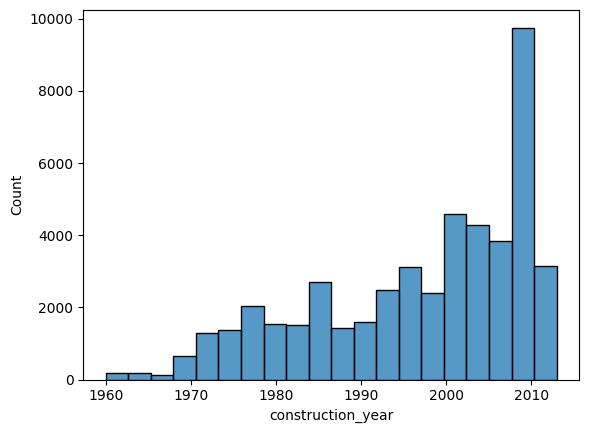

In [60]:
sns.histplot(df_pump['construction_year'].dropna(), bins=20, kde=False)

In [61]:
# Imputamos por el mas frecuente - moda
imputer = SimpleImputer(strategy='most_frequent')
df_pump['construction_year'] = imputer.fit_transform(df_pump[['construction_year']])

In [62]:
# df_pump['longitude'].value_counts(normalize=True, dropna=False)
# Remover registros malos ~2%


# df_pump['latitude'].value_counts(normalize=True, dropna=False)
# Remover registros malos ~2%

# df_pump['num_private'].value_counts(normalize=True, dropna=False)
# Eliminar columna - No hay referencias de que es y tien el 98% de nan

In [63]:
df_pump['longitude'].fillna(0, inplace=True)
df_pump['latitude'].fillna(0, inplace=True)

df_pump = df_pump[(df_pump['longitude'] != 0) | (df_pump['original_file'] == 'test')]
df_pump = df_pump[(df_pump['latitude'] != 0) | (df_pump['original_file'] == 'test')]
df_pump.drop(columns='num_private', inplace=True)

/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/1244385667.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pump['longitude'].fillna(0, inplace=True)
/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/1244385667.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [64]:
df_pump['longitude'].value_counts(dropna=False)

longitude
0.000000     287
36.072187     91
34.807859     25
31.118608     21
36.885545     20
            ... 
38.962623      1
35.388704      1
36.956682      1
33.231717      1
34.765054      1
Name: count, Length: 71977, dtype: int64

Trabajar con la variable tipo Date - que se puede extraer rapidamente valores numericos

In [65]:
df_pump['date_recorded'] = pd.to_datetime(df_pump['date_recorded'])
df_pump['year'] = df_pump['date_recorded'].dt.year
df_pump['month'] = df_pump['date_recorded'].dt.month
df_pump['day'] = df_pump['date_recorded'].dt.day
df_pump['day_of_week'] = df_pump['date_recorded'].dt.dayofweek
df_pump['day_of_week'].value_counts(normalize=True)


day_of_week
2    0.157425
3    0.149480
4    0.147811
1    0.142451
0    0.139251
5    0.139237
6    0.124345
Name: proportion, dtype: float64

In [66]:
df_pump['duracion']=(pd.to_datetime('2013-12-31') - df_pump['date_recorded']).dt.days

In [67]:
## Aplicar al final
## No borrar
# Eliminar la columna original de donde se hizo los dummies
for k in dummyable_cat_rev['Column']:
    df_pump.drop(columns=k, inplace=True)

In [68]:
# Eliminamos las categorias originales, despues que fueron transformadas
for k in high_freq_cat_rev['Column']:
    df_pump.drop(columns=k, inplace=True)

In [69]:
df_pump.drop(columns='date_recorded', inplace=True)

In [70]:
df_pump.to_csv('../data_depurada_train_test.csv')

In [71]:
data_train = df_pump[df_pump['original_file'] == 'train']
data_test = df_pump[df_pump['original_file'] == 'test']

data_train.drop(columns='original_file', inplace=True)
data_test.drop(columns='original_file', inplace=True)

data_train.to_csv('../data_train.csv')
data_test.to_csv('../data_test.csv')

/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/1780475764.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.drop(columns='original_file', inplace=True)
/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/1780475764.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.drop(columns='original_file', inplace=True)


In [72]:
print(df_label.shape)
print(data_train.shape)

data_train_complete = pd.merge(data_train, df_label, on="id", how='inner')
data_train_complete.info()

(59400, 2)
(58277, 128)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58277 entries, 0 to 58276
Columns: 129 entries, id to status_group
dtypes: bool(106), float64(5), int32(4), int64(13), object(1)
memory usage: 15.2+ MB


In [73]:
from sklearn.decomposition import PCA 

pca = PCA(2) # project from 64 to 2 dimensions
projected = pca.fit_transform(data_train_complete.drop(columns='status_group')) 
print(data_train.shape) 
print(projected.shape)

(58277, 128)
(58277, 2)


In [74]:
data_train_complete['status_group'].shape

(58277,)

In [75]:
data_target = pd.Categorical(data_train_complete['status_group']).codes

In [76]:
data_target

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/3806042256.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', 10))


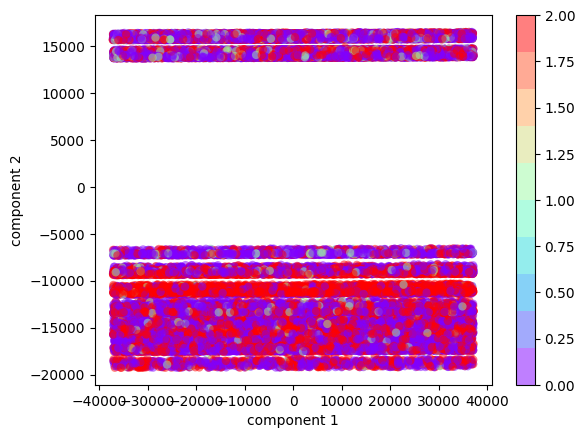

In [77]:
plt.scatter(projected[:, 0], projected[:, 1], c=data_target, 
edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', 10))
plt.xlabel('component 1') 
plt.ylabel('component 2') 
plt.colorbar();
plt.show()

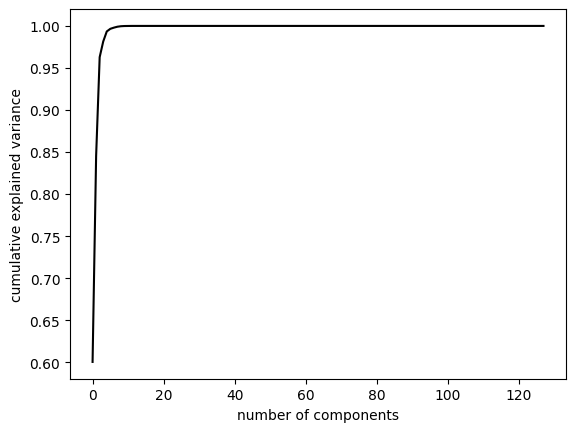

In [78]:
pca = PCA().fit(data_train_complete.drop(columns='status_group')) 
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='0') 
plt.xlabel('number of components') 
plt.ylabel('cumulative explained variance');
plt.show()

In [79]:
# Agregar la columna con las categorias respuesta
# Entrenar los modelos

In [80]:
X_train, X_test, y_train, y_test = train_test_split(data_train_complete.drop(columns='status_group', axis=1), 
                                                    data_train_complete['status_group'], 
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=data_train_complete['status_group']
                                                    )

In [81]:
data_test.shape

(14850, 128)

In [82]:
n_estimators = 20
semilla = 42
model1 = RandomForestClassifier(n_estimators=n_estimators)

In [83]:
model1.fit(X_train, y_train)
y_real = model1.predict(data_test)
y_pred = model1.predict(X_test)

pred_y = pd.DataFrame(y_real, columns=['status_group'])
data_id = data_test['id']
result1 = pd.concat([data_id.reset_index(drop=True), pred_y], axis=1)
result1[['id', 'status_group']].to_csv(".results/result1.csv", index=False)


In [84]:
y_pred = model1.predict(X_test)

#Calcular accuracy
accuracy = accuracy_score(y_test, y_pred)

In [85]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.89      0.84      7930
functional needs repair       0.52      0.31      0.39      1012
         non functional       0.84      0.77      0.80      5628

               accuracy                           0.80     14570
              macro avg       0.72      0.66      0.68     14570
           weighted avg       0.80      0.80      0.80     14570



In [86]:
saca_metricas(y_test, y_pred)

Matriz de Confusión
[[7065  197  668]
 [ 524  315  173]
 [1203   91 4334]]
Accuracy: 0.80398078242965
Precision: 0.7971420846928515
Recall: 0.80398078242965
F1 Score: 0.7969332912354943


In [87]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.89      0.84      7930
functional needs repair       0.52      0.31      0.39      1012
         non functional       0.84      0.77      0.80      5628

               accuracy                           0.80     14570
              macro avg       0.72      0.66      0.68     14570
           weighted avg       0.80      0.80      0.80     14570



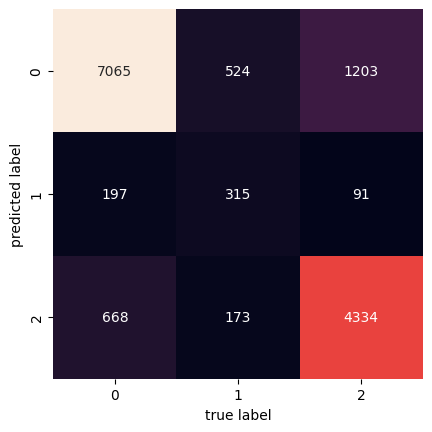

In [88]:
# from sklearn.metrics import confusion_matrix 
mat = confusion_matrix(y_test, y_pred) 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False) 
plt.xlabel('true label') 
plt.ylabel('predicted label');
plt.show()

In [89]:
# mlflow.set_experiment('Concurso_PumpitUp')

In [90]:
# import mlflow.sklearn


# with mlflow.start_run(run_name='untunned_random_forrest'):
#     model1.fit(X_train, y_train)
#     y_pred = model1.predict(X_test)

#     #Calcular accuracy
#     accuracy = accuracy_score(y_test, y_pred)

#     # Registrar parametros, metricas y modelos
#     mlflow.log_param('random_state', semilla)
#     mlflow.log_param('n_estimators', model1.n_estimators)
#     mlflow.log_param('max_depth', model1.max_depth)
#     mlflow.log_param('accuracy', accuracy)
#     mlflow.sklearn.log_model(model1, 'untunned_random_forest')

#     #Register importancia de las caracteristicas
#     feature_importance = model1.feature_importances_
#     for i, col in enumerate(X_train.columns):
#         mlflow.log_metric(f"importance_{col}", feature_importance[i])

#     # Guardar conjunto de datos de prueba
#     X_test.to_csv("X_test.csv", index=False)
#     mlflow.log_artifact("X_test.csv")

#     # Crear y guardar matriz de confusion
#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(10,7))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#     plt.xlabel('Predict')
#     plt.ylabel('Actual')
#     plt.title('Confusion Matrix')
#     plt.savefig('confusion_matrix.png')

#     print(f"Accuracy: {accuracy}")

In [91]:
# Primer ejercicio para subir a la plataforma del concurso
# Usando el modelo1 - Random Forest Clasifier - untunned

In [92]:
grid_param = {
    'n_estimators': [20, 50, 100],
    'max_depth': [15, 20,30]
}
model2 = RandomForestClassifier()
model_grid = GridSearchCV(estimator=model2,
                     param_grid=grid_param,
                     
                     cv=5,
                     n_jobs=-1)


model_grid.fit(X_train, y_train)
print(model_grid.best_params_)
print(model_grid.best_score_)

{'max_depth': 20, 'n_estimators': 100}
0.8074221729152613


In [93]:
model_n = RandomForestClassifier(max_depth=20, n_estimators=100)
model_n.fit(X_train, y_train)
y_pred = model_n.predict(X_test)

y_real = model_n.predict(data_test)

pred_y = pd.DataFrame(y_real, columns=['status_group'])
data_id = data_test['id']
result_n = pd.concat([data_id.reset_index(drop=True), pred_y], axis=1)
result_n.to_csv(".results/result3.csv", index=False)

In [94]:
saca_metricas(y_test, y_pred)

Matriz de Confusión
[[7274  112  544]
 [ 583  282  147]
 [1305   59 4264]]
Accuracy: 0.8112560054907344
Precision: 0.8077563432835988
Recall: 0.8112560054907344
F1 Score: 0.8012661485269145


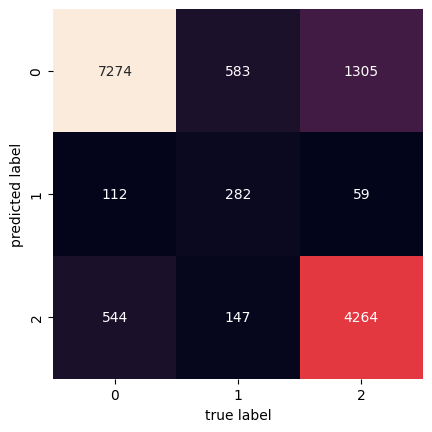

In [95]:
# from sklearn.metrics import confusion_matrix 
mat = confusion_matrix(y_test, y_pred) 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False) 
plt.xlabel('true label') 
plt.ylabel('predicted label');
plt.show()

In [96]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.79      0.92      0.85      7930
functional needs repair       0.62      0.28      0.38      1012
         non functional       0.86      0.76      0.81      5628

               accuracy                           0.81     14570
              macro avg       0.76      0.65      0.68     14570
           weighted avg       0.81      0.81      0.80     14570



In [97]:
plot_feature_importance(model_n, X_train)

Importance
longitude                             0.055564
latitude                              0.053932
quantity_dry                          0.053192
quantity_group_dry                    0.045937
id                                    0.035572
...                                        ...
waterpoint_type_cattle trough         0.000139
extraction_type_class_wind-powered    0.000128
waterpoint_type_dam                   0.000027
water_quality_fluoride abandoned      0.000026
waterpoint_type_group_dam             0.000015

[128 rows x 1 columns]

In [98]:
from sklearn.naive_bayes import GaussianNB
model3 = GaussianNB()
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)

y_real = model3.predict(data_test)

pred_y = pd.DataFrame(y_real, columns=['status_group'])
data_id = data_test['id']
result_n = pd.concat([data_id.reset_index(drop=True), pred_y], axis=1)
result_n.to_csv(".results/result4.csv", index=False)


In [99]:
saca_metricas(y_test, y_pred)

Matriz de Confusión
[[4243 1130 2557]
 [ 364  375  273]
 [1242  712 3674]]
Accuracy: 0.569114619080302
Precision: 0.6247731778862318
Recall: 0.569114619080302
F1 Score: 0.5852835043813566


In [100]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

# Define the parameter grid
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

# Create the model
model = GaussianNB()

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)


Best parameters: {'var_smoothing': 1e-09}


In [101]:
from sklearn.naive_bayes import GaussianNB
model3 = GaussianNB(var_smoothing= 1e-09)
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)

y_real = model3.predict(data_test)

pred_y = pd.DataFrame(y_real, columns=['status_group'])
data_id = data_test['id']
result_n = pd.concat([data_id.reset_index(drop=True), pred_y], axis=1)
result_n.to_csv(".results/result4.csv", index=False)

In [102]:
saca_metricas(y_test, y_pred)

Matriz de Confusión
[[4243 1130 2557]
 [ 364  375  273]
 [1242  712 3674]]
Accuracy: 0.569114619080302
Precision: 0.6247731778862318
Recall: 0.569114619080302
F1 Score: 0.5852835043813566


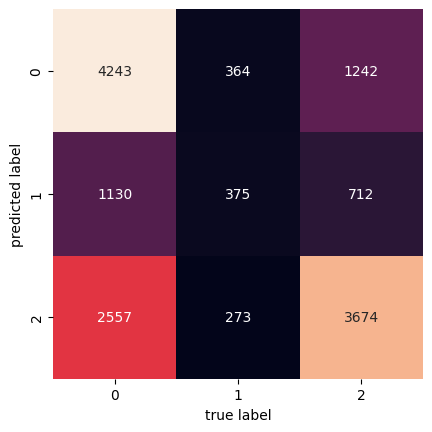

In [103]:
# from sklearn.metrics import confusion_matrix 
mat = confusion_matrix(y_test, y_pred) 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False) 
plt.xlabel('true label') 
plt.ylabel('predicted label');
plt.show()

In [104]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.73      0.54      0.62      7930
functional needs repair       0.17      0.37      0.23      1012
         non functional       0.56      0.65      0.61      5628

               accuracy                           0.57     14570
              macro avg       0.49      0.52      0.48     14570
           weighted avg       0.62      0.57      0.59     14570



In [105]:
plot_feature_importance(model1, X_train)

Importance
longitude                             0.064505
latitude                              0.063985
id                                    0.049062
quantity_dry                          0.040142
gps_height                            0.038675
...                                        ...
waterpoint_type_cattle trough         0.000145
extraction_type_class_wind-powered    0.000133
water_quality_fluoride abandoned      0.000019
waterpoint_type_group_dam             0.000019
waterpoint_type_dam                   0.000015

[128 rows x 1 columns]

In [106]:
# model_n = RandomForestClassifier(max_depth=20, n_estimators=50)
# model_n.fit(X_train, y_train)
# y_real = model_n.predict(data_test)

# pred_y = pd.DataFrame(y_real, columns=['status_group'])
# data_id = data_test['id']
# result_n = pd.concat([data_id.reset_index(drop=True), pred_y], axis=1)
# result_n.to_csv(".results/result2.csv", index=False)

In [107]:
y_test.shape

(14570,)

In [108]:
data_train_complete.head()

id  amount_tsh  gps_height  longitude   latitude  region_code  \
0  69572      6000.0        1390  34.938093  -9.856322           11   
1   8776         0.0        1399  34.698766  -2.147466           20   
2  34310        25.0         686  37.460664  -3.821329           21   
3  67743         0.0         263  38.486161 -11.155298           90   
4  19728         0.0           0  31.130847  -1.825359           18   

   district_code  population  construction_year  basin_Internal  ...  \
0              5       109.0             1999.0           False  ...   
1              2       280.0             2010.0           False  ...   
2              4       250.0             2009.0           False  ...   
3             63        58.0             1986.0           False  ...   
4              1       200.0             2010.0           False  ...   

   region_freq  lga_freq  ward_freq  extraction_type_freq  year  month  day  \
0         6599       687         41                 33263  2011      3   14   
1         2451       905         90                 33263  2013      3    6   
2         1972       372         13                 33263  2013      2   25   
3         2144       213         41                  5982  2013      1   28   
4         4174       967         14                 33263  2011      7   13   

   day_of_week  duracion    status_group  
0            0      1023      functional  
1            2       300      functional  
2            0       309      functional  
3            0       337  non functional  
4            2       902      functional  

[5 rows x 129 columns]

In [109]:
# data_train_complete['status_group'].head()
data_train_complete['status_group_encoded'] = pd.Categorical(data_train_complete['status_group']).codes
# data_train_complete['status_group_encoded'].groupby(data_train_complete['id']).mean() * 100

data = data_train_complete.drop(columns='status_group', inplace=True)

# data_train_complete['status_group_encoded'].groupby(data_train_complete['id']).mean() * 100

In [110]:
for i in data_train_complete.columns:
    plot_target_vs_features (i, 'status_group_encoded', data_train_complete)

/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/3151680715.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/3151680715.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/3151680715.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/3151680715.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/3151680715.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/3151680715.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/3151680715.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/3151680715.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/3151680715.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/3151680715.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/3151680715.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/3151680715.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/3151680715.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/3151680715.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/3151680715.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/3151680715.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [111]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.4)
selector.fit_transform(data_train_complete)

array([[6.9572e+04, 6.0000e+03, 1.3900e+03, ..., 0.0000e+00, 1.0230e+03,
        0.0000e+00],
       [8.7760e+03, 0.0000e+00, 1.3990e+03, ..., 2.0000e+00, 3.0000e+02,
        0.0000e+00],
       [3.4310e+04, 2.5000e+01, 6.8600e+02, ..., 0.0000e+00, 3.0900e+02,
        0.0000e+00],
       ...,
       [3.7057e+04, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 9.9500e+02,
        0.0000e+00],
       [3.1282e+04, 0.0000e+00, 0.0000e+00, ..., 1.0000e+00, 1.0290e+03,
        0.0000e+00],
       [2.6348e+04, 0.0000e+00, 1.9100e+02, ..., 2.0000e+00, 1.0140e+03,
        0.0000e+00]])

In [112]:
selector.get_feature_names_out()

array(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'region_code', 'district_code', 'population', 'construction_year',
       'funder_freq', 'installer_freq', 'wpt_name_freq',
       'subvillage_freq', 'region_freq', 'lga_freq', 'ward_freq',
       'extraction_type_freq', 'year', 'month', 'day', 'day_of_week',
       'duracion', 'status_group_encoded'], dtype=object)

In [113]:
lista_final = ['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'region_code', 'district_code', 'population', 'construction_year',
       'funder_freq', 'installer_freq', 'wpt_name_freq',
       'subvillage_freq', 'region_freq', 'lga_freq', 'ward_freq',
       'extraction_type_freq', 'year', 'month', 'day', 'day_of_week',
       'duracion']

In [114]:
data_train = pd.read_csv('../data_train.csv')
data_test = pd.read_csv('../data_test.csv')

df_label = pd.read_csv('training_labels.csv', delimiter=',')

In [115]:
print(df_label.shape)
print(data_train.shape)

data_train_complete = pd.merge(data_train, df_label, on="id", how='inner')
data_train_complete.info()

(59400, 2)
(58277, 129)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58277 entries, 0 to 58276
Columns: 130 entries, Unnamed: 0 to status_group
dtypes: bool(106), float64(5), int64(18), object(1)
memory usage: 16.6+ MB


In [116]:
X_train, X_test, y_train, y_test = train_test_split(data_train_complete.drop(columns='status_group', axis=1), 
                                                    data_train_complete['status_group'], 
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=data_train_complete['status_group']
                                                    )

In [117]:
grid_param = {
    'n_estimators': [20, 50, 100, 150, 200],
    'max_depth': [15, 20,30, 50]
}
model2 = RandomForestClassifier()
model_grid = GridSearchCV(estimator=model2,
                     param_grid=grid_param,
                     
                     cv=5,
                     n_jobs=-1)


model_grid.fit(X_train, y_train)
print(model_grid.best_params_)
print(model_grid.best_score_)

{'max_depth': 30, 'n_estimators': 200}
0.8092525826021371


In [118]:
model_n = RandomForestClassifier(max_depth=30, n_estimators=200)
model_n.fit(X_train[lista_final], y_train)
y_pred = model_n.predict(X_test[lista_final])

y_real = model_n.predict(data_test[lista_final])

pred_y = pd.DataFrame(y_real, columns=['status_group'])
data_id = data_test['id']
result_n = pd.concat([data_id.reset_index(drop=True), pred_y], axis=1)
result_n.to_csv(".results/result_final.csv", index=False)

In [119]:
saca_metricas(y_test, y_pred)

Matriz de Confusión
[[6758  169 1003]
 [ 505  298  209]
 [1432   86 4110]]
Accuracy: 0.76636925188744
Precision: 0.7587562910998068
Recall: 0.76636925188744
F1 Score: 0.7589077425832556


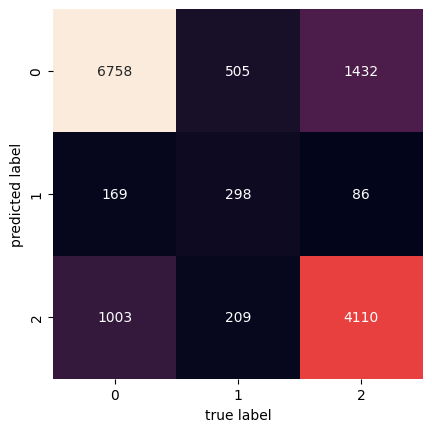

In [120]:
# from sklearn.metrics import confusion_matrix 
mat = confusion_matrix(y_test, y_pred) 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False) 
plt.xlabel('true label') 
plt.ylabel('predicted label');
plt.show()

In [121]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.78      0.85      0.81      7930
functional needs repair       0.54      0.29      0.38      1012
         non functional       0.77      0.73      0.75      5628

               accuracy                           0.77     14570
              macro avg       0.70      0.63      0.65     14570
           weighted avg       0.76      0.77      0.76     14570



In [122]:
X_train = X_train[lista_final]
X_test = X_test[lista_final]

In [123]:
sampling_strategy = {
    'functional': 50000,  # Replace with the desired number of samples for this class
    'non functional': 50000,
    'functional needs repair': 30000
}

sm = SMOTE(random_state=2,sampling_strategy=sampling_strategy)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_78194/1073706220.py:8: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.



In [124]:
model4 = RandomForestClassifier(max_depth=30, n_estimators=200).fit(X_train_res,y_train_res)
y_pred= model4.predict(X_test)

In [125]:
saca_metricas(y_test, y_pred)

Matriz de Confusión
[[6578  264 1088]
 [ 443  356  213]
 [1348  130 4150]]
Accuracy: 0.7607412491420728
Precision: 0.7548432080276164
Recall: 0.7607412491420728
F1 Score: 0.7567648219359655


In [126]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.79      0.83      0.81      7930
functional needs repair       0.47      0.35      0.40      1012
         non functional       0.76      0.74      0.75      5628

               accuracy                           0.76     14570
              macro avg       0.67      0.64      0.65     14570
           weighted avg       0.75      0.76      0.76     14570



In [129]:
import lime
import shap
from lime import lime_tabular

In [130]:
X_train_res

id  amount_tsh  gps_height  longitude  latitude  region_code  \
0       65870    0.000000           0  33.172677 -4.647531           14   
1       62722   20.000000          49  38.781169 -6.641616            6   
2       72610    0.000000         282  36.893325 -7.851713            5   
3       61314  500.000000        1554  34.603874 -9.011652           11   
4       27401    0.000000           0  30.697643 -1.258947           18   
...       ...         ...         ...        ...       ...          ...   
129995  39073    0.000000           0  33.311642 -9.035823           12   
129996  20370    0.000000           0  37.510058 -5.802602            4   
129997  28314    0.000000         146  35.054574 -8.079250            8   
129998  56353   18.350089          77  35.705819 -4.739100           10   
129999  19755    0.000000         487  37.059613 -8.984216           72   

        district_code   population  construction_year  funder_freq  ...  \
0                   1   200.000000        2010.000000        11299  ...   
1                   2     1.000000        1998.000000           92  ...   
2                   3   300.000000        1998.000000         1065  ...   
3                   4   250.000000        1978.000000         1324  ...   
4                   1   200.000000        2010.000000        11299  ...   
...               ...          ...                ...          ...  ...   
129995              5   200.000000        2010.000000         3907  ...   
129996              6  1794.168812        1989.720323           89  ...   
129997              4   243.271652        2003.941969         1381  ...   
129998              1   108.249555        2010.000000           64  ...   
129999             38   331.515751        1976.682676        11299  ...   

        subvillage_freq  region_freq  lga_freq  ward_freq  \
0                     2         2466       730         13   
1                    14         3331       358         56   
2                     5         5038      1207        122   
3                   129         6599      3128        222   
4                     1         4174       967         59   
...                 ...          ...       ...        ...   
129995                4         5758      1255        114   
129996               23         3161       220          6   
129997              281         5446      1013         54   
129998               11         3658       968        167   
129999                4         2197       219         21   

        extraction_type_freq  year  month  day  day_of_week  duracion  
0                       8102  2013      2    1            4       333  
1                       5982  2011      3   19            5      1018  
2                      33263  2011      3   25            4      1012  
3                      33263  2011     10    4            1       819  
4                      33263  2011      7   31            6       884  
...                      ...   ...    ...  ...          ...       ...  
129995                 33263  2011      4   11            4       981  
129996                  4588  2011      3   27            0       989  
129997                  4588  2011      4   18            3       961  
129998                  1790  2011      4   18            0       970  
129999                  1574  2012      1   23            4       408  

[130000 rows x 22 columns]

In [131]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_res.values, 
                                                   mode='classification',
                                                   training_labels=y_train_res,
                                                   feature_names=X_train_res.columns,
                                                   random_state=42)

In [132]:
X_train_res

id  amount_tsh  gps_height  longitude  latitude  region_code  \
0       65870    0.000000           0  33.172677 -4.647531           14   
1       62722   20.000000          49  38.781169 -6.641616            6   
2       72610    0.000000         282  36.893325 -7.851713            5   
3       61314  500.000000        1554  34.603874 -9.011652           11   
4       27401    0.000000           0  30.697643 -1.258947           18   
...       ...         ...         ...        ...       ...          ...   
129995  39073    0.000000           0  33.311642 -9.035823           12   
129996  20370    0.000000           0  37.510058 -5.802602            4   
129997  28314    0.000000         146  35.054574 -8.079250            8   
129998  56353   18.350089          77  35.705819 -4.739100           10   
129999  19755    0.000000         487  37.059613 -8.984216           72   

        district_code   population  construction_year  funder_freq  ...  \
0                   1   200.000000        2010.000000        11299  ...   
1                   2     1.000000        1998.000000           92  ...   
2                   3   300.000000        1998.000000         1065  ...   
3                   4   250.000000        1978.000000         1324  ...   
4                   1   200.000000        2010.000000        11299  ...   
...               ...          ...                ...          ...  ...   
129995              5   200.000000        2010.000000         3907  ...   
129996              6  1794.168812        1989.720323           89  ...   
129997              4   243.271652        2003.941969         1381  ...   
129998              1   108.249555        2010.000000           64  ...   
129999             38   331.515751        1976.682676        11299  ...   

        subvillage_freq  region_freq  lga_freq  ward_freq  \
0                     2         2466       730         13   
1                    14         3331       358         56   
2                     5         5038      1207        122   
3                   129         6599      3128        222   
4                     1         4174       967         59   
...                 ...          ...       ...        ...   
129995                4         5758      1255        114   
129996               23         3161       220          6   
129997              281         5446      1013         54   
129998               11         3658       968        167   
129999                4         2197       219         21   

        extraction_type_freq  year  month  day  day_of_week  duracion  
0                       8102  2013      2    1            4       333  
1                       5982  2011      3   19            5      1018  
2                      33263  2011      3   25            4      1012  
3                      33263  2011     10    4            1       819  
4                      33263  2011      7   31            6       884  
...                      ...   ...    ...  ...          ...       ...  
129995                 33263  2011      4   11            4       981  
129996                  4588  2011      3   27            0       989  
129997                  4588  2011      4   18            3       961  
129998                  1790  2011      4   18            0       970  
129999                  1574  2012      1   23            4       408  

[130000 rows x 22 columns]

In [133]:
X_train_res.iloc[7]

id                       2554.000000
amount_tsh                  0.000000
gps_height               2148.000000
longitude                  34.641974
latitude                   -9.554192
region_code                11.000000
district_code               4.000000
population                 40.000000
construction_year        2008.000000
funder_freq               103.000000
installer_freq             69.000000
wpt_name_freq            4440.000000
subvillage_freq            12.000000
region_freq              6599.000000
lga_freq                 3128.000000
ward_freq                 177.000000
extraction_type_freq    33263.000000
year                     2011.000000
month                       2.000000
day                        26.000000
day_of_week                 5.000000
duracion                 1039.000000
Name: 7, dtype: float64

In [135]:
from IPython.display import display, HTML

exp=explainer.explain_instance(X_train_res.iloc[7], model_n.predict_proba)
#exp.show_in_notebook(show_all=False)
display(HTML(exp.as_html()))

/opt/anaconda3/envs/Mineria/lib/python3.11/site-packages/lime/discretize.py:110: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/opt/anaconda3/envs/Mineria/lib/python3.11/site-packages/lime/discretize.py:110: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

/opt/anaconda3/envs/Mineria/lib/python3.11/site-packages/lime/lime_tabular.py:544: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/opt/anaconda3/envs/Mineria/lib/python3.11/site-

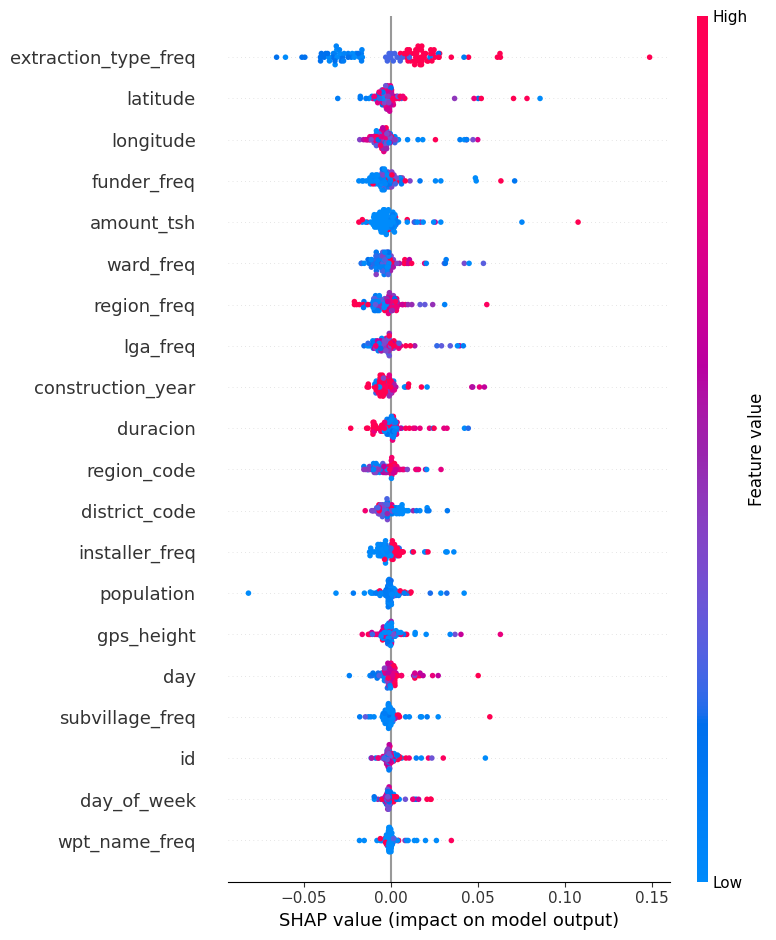

In [136]:
explainer = shap.Explainer(model_n)
shap_values = explainer.shap_values(X_train_res.iloc[0:100])
shap.summary_plot(shap_values[:,:,1], X_train_res.iloc[0:100])